In [ ]:
# OPENROUTER_API_KEY
#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
#Tavily API:
# 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


: 

In [ ]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages,StateGraph,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json
import os

: 

In [ ]:
load_dotenv()

print(os.getenv("OPENROUTER_API_KEY"))
model=ChatOpenAI(
    model="deepseek/deepseek-r1",
    openai_api_key=os.getenv("OPENROUTER_API_KEY"),
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.2,)
# response=model.invoke("Give me a joka about cats")
# response

: 

In [31]:
search_tool=TavilySearchResults(max_results=4)

# response=search_tool.invoke("What is the weather in Boca Raton")
# response

In [32]:
tools=[search_tool]
memory=MemorySaver()

In [33]:
llm_with_tools=model.bind_tools(tools=tools)
# response= llm_with_tools.invoke("What is the current weather in Banglore")
# response



In [34]:
from langchain_core.messages import AIMessage,HumanMessage,ToolMessage
class State(TypedDict):
    message: Annotated[list,add_messages]
async def model(state: State):
    result=await llm_with_tools.ainvoke(state["message"])
    return {
        "message":[result]
    }
async def tools_router(state: State):
    last_message=state["message"][-1]
    if(hasattr(last_message,"tool_calls") and len(last_message.tool_calls) >0):
        return "tool_node"
    else:
        return END

async def tool_node(state):
    tool_calls=state["message"][-1].tool_calls
    tool_messages=[]
    for tool_call in tool_calls:
        tool_name=tool_call["name"]
        tool_args=tool_call["args"]
        tool_id=tool_call["id"]
        if tool_name=="tavily_search_results":
            search_results=await search_tool.ainvoke(tool_args)
            tool_message=ToolMessage(content=str(search_results),tool_call_id=tool_id,name=tool_name)
            tool_messages.append(tool_message)
    return {"message":tool_messages}

graph_builder=StateGraph(State)
graph_builder.add_node("model",model)
graph_builder.add_node("tool_node",tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model",tools_router)
graph_builder.add_edge("tool_node","model")

graph=graph_builder.compile(checkpointer=memory)



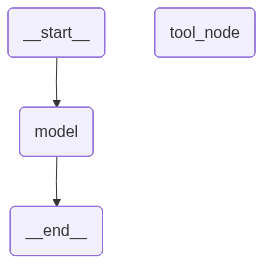

In [35]:
from IPython.display import Image,display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [ ]:
config={
    "configurable":{
    "thread_id":7
}
}

response= await graph.ainvoke({
    "message":[HumanMessage(content="How to stud?")],},config=config)
response

{'message': [HumanMessage(content='when is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='46f73fda-269a-4c21-aaeb-7fa47437198a'),
  AIMessage(content="I'll find the latest information on the next SpaceX launch for you.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 154, 'total_tokens': 267, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 72, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'deepseek/deepseek-r1', 'system_fingerprint': '', 'id': 'gen-1764190703-rot3y0vakn6Vgc5nIkMX', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--f46b18b6-5432-4a41-bf06-be9d99bce6ed-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch date'}, 'id

In [40]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

async for event in graph.astream_events(
    {
        "message": [HumanMessage(content="Give me a 100 word essay on swimming")]
    },
    config=config,
    version="v2"
):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)


I'll craft a concise 100-word essay on swimming. Here it is:Swimming is a versatile and beneficial activity that engages the entire body while offering both physical and mental rewards. As a low-impact exercise, it strengthens muscles, enhances cardiovascular health, and improves endurance without straining joints. Beyond fitness, swimming promotes relaxation and reduces stress, making it an ideal way to unwind. It also serves as a crucial life skill, enhancing water safety and confidence. Whether practiced leisurely or competitively, swimming fosters discipline and perseverance. Accessible to people of all ages and abilities, it remains a timeless pursuit that unites fun, fitness, and well-being in every stroke.